In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, concatenate, Dense, Flatten, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [4]:
# Import dataset
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle

df = pd.read_csv(r"training_data/AIFdb_Toni.csv")
display(df)
df = shuffle(df).reset_index(drop=True)

attack_count = df[df['relationship'] == "a"].count().iloc[0]
support_count = df[df['relationship'] == "s"].count().iloc[0]
neither_count = df[df['relationship'] == "n"].count().iloc[0]

print(attack_count, support_count, neither_count)

# Split features and labels
X = df[["argument1", "argument2"]].T.reset_index(drop=True).T
y = df[["relationship"]].T.reset_index(drop=True).T

display(X)
display(y)

,Unnamed: 0,argument1,argument2,relationship
0,0,"""Nancy’s skipping over Sean""","""Sean wants Nancy to bring the problems to him...",s
1,1,"""Sean does not know what’s bothering Nancy if ...","""what Sean and Nancy could do is Sean sets the...",s
2,2,"""Sean can’t read minds""","""Sean does not know what’s bothering Nancy if ...",s
3,3,"""Sean doesn’t want to feel like Nancy and Sean...","""what Sean and Nancy could do is Sean sets the...",a
4,4,"""Sean doesn't want to get all heated up and an...","""Nancy and Sean should have a drink together""",s
...,...,...,...,...
35899,35899,"""says Oregon’s law has the potential to be “ab...","""In essence, it seems as though the central cl...",n
35900,35900,"""And why do you suppose they aren't? Could it ...","""My goal is to reach the people""",n
35901,35901,"""lol...you read my whole post only to conclude...","""In general, I think that blanket policies on ...",n
35902,35902,"""No. you're not making any sense. Where is sym...","""Japanese ISPs To Ban FileSharers""",n


12158 11591 12155


,0,1
0,"""Over almost a decade since, the now 27 flouri...","""She was right"""
1,"""{P5 A0} It becomes clear from other passages ...","""North Koreans refugees are asylum seekers in ..."
2,"""As much as it pains me I'm going to agree wit...","""NO I think that if certain religious groups c..."
3,"""Well, here is my take on it. I really believe...","""I have never received an actual explanation f..."
4,"""we have to help these tracers to get at least...","""we should be doing more to control the virus"""
...,...,...
35899,"""Она жертва.""","""Она виновна"""
35900,"""And that doesn't make you wrong? But it only ...","""but this is the point isn't it? You just knew..."
35901,"""good to know, I have been able to really use ...","""netbooks are better than the ivagina"""
35902,"""Lauren and Alice don’t know what each other’s...","""it’s quite a thin slice"""


,0
0,s
1,n
2,s
3,s
4,s
...,...
35899,a
35900,n
35901,a
35902,s


In [5]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split pairs of sentences
sentences_train_1 = X_train[0].to_numpy()
sentences_train_2 = X_train[1].to_numpy()

sentences_test_1 = X_test[0].to_numpy()
sentences_test_2 = X_test[1].to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# prepare target
le = LabelEncoder()
le.fit(np.ravel(y))
y_train_enc = le.transform(np.ravel(y_train))
y_test_enc = le.transform(np.ravel(y_test))
print(y_test_enc)

# one hot encoded
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print(y_train_enc, y_test_enc)

[2 2 0 ... 0 2 2]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]] [[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Flatten features for Glove fitting
texts = np.concatenate([X[0], X[1]])

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Encode training data
sequences_train_1 = tokenizer.texts_to_sequences(sentences_train_1)
sequences_train_2 = tokenizer.texts_to_sequences(sentences_train_2)

# Encode testing data
sequences_test_1 = tokenizer.texts_to_sequences(sentences_test_1)
sequences_test_2 = tokenizer.texts_to_sequences(sentences_test_2)

# Padding sequences to have the same length
max_len = 50
print(max_len)

padded_sequences_train_1 = pad_sequences(sequences_train_1, maxlen=max_len, padding='post')
padded_sequences_train_2 = pad_sequences(sequences_train_2, maxlen=max_len, padding='post')

padded_sequences_test_1 = pad_sequences(sequences_test_1, maxlen=max_len, padding='post')
padded_sequences_test_2 = pad_sequences(sequences_test_2, maxlen=max_len, padding='post')

#print(padded_sequences_test_2)

50


In [8]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [76]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_32 (Embedding)    (None, 50, 300)              1644120   ['input_33[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_33 (Embedding)    (None, 50, 300)              1644120   ['input_34[0][0]']     

In [77]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 37s 145ms/step - loss: 0.8868 - accuracy: 0.5937 - val_loss: 0.8181 - val_accuracy: 0.6599
Epoch 2/50
202/202 [==============================] - 29s 143ms/step - loss: 0.7712 - accuracy: 0.6697 - val_loss: 0.7672 - val_accuracy: 0.6707
Epoch 3/50
202/202 [==============================] - 31s 152ms/step - loss: 0.7045 - accuracy: 0.7004 - val_loss: 0.7312 - val_accuracy: 0.6892
Epoch 4/50
 23/202 [==>...........................] - ETA: 25s - loss: 0.6164 - accuracy: 0.7503

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

In [ ]:
results = model.evaluate([padded_sequences_test_1, padded_sequences_test_2], y_test_enc, batch_size=32)
print("test loss, test acc:", results)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
model.save('../saved_models/IBM_model_full_300_better')

INFO:tensorflow:Assets written to: ../saved_models/IBM_model_full_300_better/assets


INFO:tensorflow:Assets written to: ../saved_models/IBM_model_full_300_better/assets


In [17]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# BASE MODEL

In [6]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
base_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 100)              5480400   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 100)              5480400   ['input_2[0][0]']             
                                                                                              

In [8]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = base_model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 38s 177ms/step - loss: 0.8622 - accuracy: 0.6132 - val_loss: 0.7681 - val_accuracy: 0.6634
Epoch 2/50
202/202 [==============================] - 39s 194ms/step - loss: 0.7033 - accuracy: 0.7053 - val_loss: 0.7179 - val_accuracy: 0.6906
Epoch 3/50
202/202 [==============================] - 37s 185ms/step - loss: 0.5813 - accuracy: 0.7601 - val_loss: 0.7364 - val_accuracy: 0.6871
Epoch 4/50
202/202 [==============================] - 34s 170ms/step - loss: 0.4605 - accuracy: 0.8161 - val_loss: 0.7689 - val_accuracy: 0.6989
Epoch 5/50
202/202 [==============================] - 34s 170ms/step - loss: 0.3454 - accuracy: 0.8647 - val_loss: 0.8504 - val_accuracy: 0.6930
Epoch 6/50
202/202 [==============================] - 33s 165ms/step - loss: 0.2486 - accuracy: 0.9064 - val_loss: 0.9455 - val_accuracy: 0.6940
Epoch 7/50
202/202 [==============================] - 33s 164ms/step - loss: 0.1763 - accuracy: 0.9360 - val_loss: 1.1570 - val_ac

In [9]:
from sklearn.metrics import classification_report
y_pred = base_model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 2s 3ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.66      0.77      0.71      2447
           1       0.73      0.61      0.66      2471
           2       0.72      0.73      0.73      2264

    accuracy                           0.70      7182
   macro avg       0.70      0.70      0.70      7182
weighted avg       0.70      0.70      0.70      7182



In [10]:
# BASE MODEL WITH 300D GLOVE

In [11]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 300)              1644120   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_3 (Embedding)     (None, 50, 300)              1644120   ['input_4[0][0]']       

In [13]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 98s 471ms/step - loss: 0.8548 - accuracy: 0.6171 - val_loss: 0.7522 - val_accuracy: 0.6812
Epoch 2/50
202/202 [==============================] - 86s 424ms/step - loss: 0.6389 - accuracy: 0.7330 - val_loss: 0.7269 - val_accuracy: 0.6885
Epoch 3/50
202/202 [==============================] - 88s 434ms/step - loss: 0.4654 - accuracy: 0.8149 - val_loss: 0.7812 - val_accuracy: 0.6808
Epoch 4/50
202/202 [==============================] - 85s 419ms/step - loss: 0.3042 - accuracy: 0.8844 - val_loss: 0.9105 - val_accuracy: 0.6742
Epoch 5/50
202/202 [==============================] - 85s 422ms/step - loss: 0.1872 - accuracy: 0.9320 - val_loss: 1.1280 - val_accuracy: 0.6815


In [14]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 2s 4ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      2447
           1       0.72      0.59      0.65      2471
           2       0.69      0.75      0.72      2264

    accuracy                           0.69      7182
   macro avg       0.69      0.69      0.69      7182
weighted avg       0.69      0.69      0.69      7182



In [15]:
# BASE MODEL WITH 300D GLOVE + 128D LSTM

In [16]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 300)              1644120   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_5 (Embedding)     (None, 50, 300)              1644120   ['input_6[0][0]']       

In [17]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 113s 546ms/step - loss: 0.8373 - accuracy: 0.6259 - val_loss: 0.7500 - val_accuracy: 0.6794
Epoch 2/50
202/202 [==============================] - 108s 536ms/step - loss: 0.6320 - accuracy: 0.7392 - val_loss: 0.6885 - val_accuracy: 0.7101
Epoch 3/50
202/202 [==============================] - 109s 540ms/step - loss: 0.4581 - accuracy: 0.8175 - val_loss: 0.7498 - val_accuracy: 0.7268
Epoch 4/50
202/202 [==============================] - 111s 552ms/step - loss: 0.2941 - accuracy: 0.8898 - val_loss: 0.8975 - val_accuracy: 0.6871
Epoch 5/50
202/202 [==============================] - 111s 549ms/step - loss: 0.1764 - accuracy: 0.9365 - val_loss: 1.0608 - val_accuracy: 0.6982
Epoch 6/50
202/202 [==============================] - 111s 549ms/step - loss: 0.1017 - accuracy: 0.9646 - val_loss: 1.2703 - val_accuracy: 0.6993


In [18]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 5s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2447
           1       0.77      0.60      0.67      2471
           2       0.73      0.73      0.73      2264

    accuracy                           0.71      7182
   macro avg       0.72      0.71      0.71      7182
weighted avg       0.72      0.71      0.71      7182



In [19]:
# BASE MODEL + 300D GLOVE + 128D LSTM + 1DPOOLING & l2

In [20]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 300)              1644120   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_7 (Embedding)     (None, 50, 300)              1644120   ['input_8[0][0]']       

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 32s 147ms/step - loss: 1.0914 - accuracy: 0.5966 - val_loss: 0.9238 - val_accuracy: 0.6373
Epoch 2/50
202/202 [==============================] - 30s 148ms/step - loss: 0.8609 - accuracy: 0.6547 - val_loss: 0.8808 - val_accuracy: 0.6189
Epoch 3/50
202/202 [==============================] - 32s 156ms/step - loss: 0.8089 - accuracy: 0.6739 - val_loss: 0.8147 - val_accuracy: 0.6833
Epoch 4/50
202/202 [==============================] - 30s 148ms/step - loss: 0.7622 - accuracy: 0.6961 - val_loss: 0.8042 - val_accuracy: 0.6853
Epoch 5/50
202/202 [==============================] - 28s 136ms/step - loss: 0.7244 - accuracy: 0.7197 - val_loss: 0.7664 - val_accuracy: 0.7115
Epoch 6/50
202/202 [==============================] - 27s 133ms/step - loss: 0.6978 - accuracy: 0.7302 - val_loss: 0.7504 - val_accuracy: 0.7156
Epoch 7/50
202/202 [==============================] - 26s 131ms/step - loss: 0.6473 - accuracy: 0.7563 - val_loss: 0.7545 - val_ac

In [22]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 6s 12ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.67      0.81      0.74      2447
           1       0.81      0.61      0.69      2471
           2       0.72      0.75      0.74      2264

    accuracy                           0.72      7182
   macro avg       0.73      0.72      0.72      7182
weighted avg       0.73      0.72      0.72      7182



In [23]:
# BASE MODEL + 300D GLOVE + 128D BiLSTM

In [24]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 50, 300)              1644120   ['input_9[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_9 (Embedding)     (None, 50, 300)              1644120   ['input_10[0][0]']      

In [25]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 147s 702ms/step - loss: 0.8457 - accuracy: 0.6226 - val_loss: 0.7636 - val_accuracy: 0.6645
Epoch 2/50
202/202 [==============================] - 145s 716ms/step - loss: 0.6142 - accuracy: 0.7477 - val_loss: 0.7152 - val_accuracy: 0.7038
Epoch 3/50
202/202 [==============================] - 143s 709ms/step - loss: 0.4145 - accuracy: 0.8398 - val_loss: 0.7965 - val_accuracy: 0.6937
Epoch 4/50
202/202 [==============================] - 144s 711ms/step - loss: 0.2573 - accuracy: 0.9043 - val_loss: 0.9487 - val_accuracy: 0.6982
Epoch 5/50
202/202 [==============================] - 144s 711ms/step - loss: 0.1520 - accuracy: 0.9462 - val_loss: 1.1547 - val_accuracy: 0.6989


In [26]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 9s 18ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      2447
           1       0.71      0.60      0.65      2471
           2       0.68      0.75      0.72      2264

    accuracy                           0.69      7182
   macro avg       0.69      0.69      0.69      7182
weighted avg       0.69      0.69      0.69      7182



In [27]:
# BASE MODEL + 300D GLOVE + 128D LSTM

In [28]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 300)              1644120   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 300)              1644120   ['input_12[0][0]']      

In [29]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 31s 143ms/step - loss: 0.8666 - accuracy: 0.6115 - val_loss: 0.7886 - val_accuracy: 0.6565
Epoch 2/50
202/202 [==============================] - 29s 145ms/step - loss: 0.7327 - accuracy: 0.6895 - val_loss: 0.7522 - val_accuracy: 0.6773
Epoch 3/50
202/202 [==============================] - 29s 141ms/step - loss: 0.6436 - accuracy: 0.7335 - val_loss: 0.7044 - val_accuracy: 0.7090
Epoch 4/50
202/202 [==============================] - 28s 138ms/step - loss: 0.5550 - accuracy: 0.7717 - val_loss: 0.7762 - val_accuracy: 0.6836
Epoch 5/50
202/202 [==============================] - 28s 139ms/step - loss: 0.4683 - accuracy: 0.8141 - val_loss: 0.7297 - val_accuracy: 0.7066
Epoch 6/50
202/202 [==============================] - 30s 149ms/step - loss: 0.3780 - accuracy: 0.8526 - val_loss: 0.8012 - val_accuracy: 0.6968


In [30]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 5s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      2447
           1       0.72      0.64      0.68      2471
           2       0.74      0.70      0.72      2264

    accuracy                           0.70      7182
   macro avg       0.70      0.70      0.70      7182
weighted avg       0.70      0.70      0.70      7182



In [31]:
# Attention upgraded

In [32]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 50, 300)              1644120   ['input_13[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_13 (Embedding)    (None, 50, 300)              1644120   ['input_14[0][0]']      

In [33]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 37s 161ms/step - loss: 0.8977 - accuracy: 0.5789 - val_loss: 0.7932 - val_accuracy: 0.6509
Epoch 2/50
202/202 [==============================] - 31s 153ms/step - loss: 0.7686 - accuracy: 0.6662 - val_loss: 0.7671 - val_accuracy: 0.6634
Epoch 3/50
202/202 [==============================] - 31s 154ms/step - loss: 0.6748 - accuracy: 0.7125 - val_loss: 0.7204 - val_accuracy: 0.6954
Epoch 4/50
202/202 [==============================] - 31s 154ms/step - loss: 0.5864 - accuracy: 0.7571 - val_loss: 0.7218 - val_accuracy: 0.7125
Epoch 5/50
202/202 [==============================] - 31s 152ms/step - loss: 0.5062 - accuracy: 0.7945 - val_loss: 0.7294 - val_accuracy: 0.7128
Epoch 6/50
202/202 [==============================] - 31s 152ms/step - loss: 0.4296 - accuracy: 0.8299 - val_loss: 0.7804 - val_accuracy: 0.7163
Epoch 7/50
202/202 [==============================] - 31s 152ms/step - loss: 0.3620 - accuracy: 0.8578 - val_loss: 0.8183 - val_ac

In [34]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 7s 11ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.67      0.79      0.73      2447
           1       0.74      0.63      0.68      2471
           2       0.74      0.71      0.72      2264

    accuracy                           0.71      7182
   macro avg       0.72      0.71      0.71      7182
weighted avg       0.71      0.71      0.71      7182



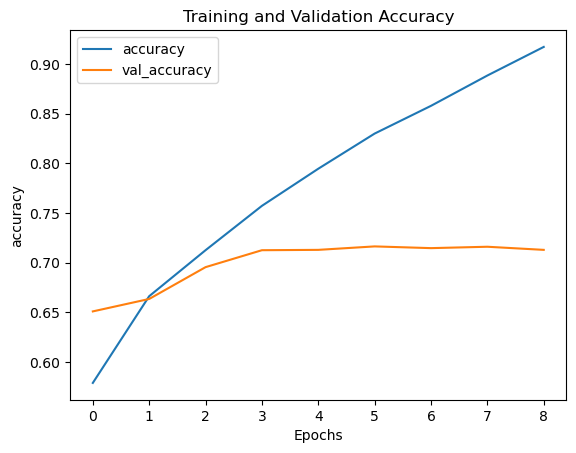

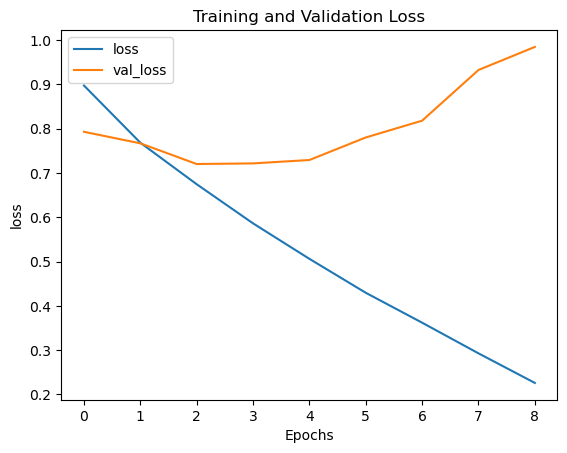

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
# Attention + BiLSTM

In [37]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 50, 300)              1644120   ['input_15[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_15 (Embedding)    (None, 50, 300)              1644120   ['input_16[0][0]']      

In [38]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 77s 337ms/step - loss: 0.8827 - accuracy: 0.6045 - val_loss: 0.7963 - val_accuracy: 0.6551
Epoch 2/50
202/202 [==============================] - 64s 318ms/step - loss: 0.7255 - accuracy: 0.6918 - val_loss: 0.7561 - val_accuracy: 0.6857
Epoch 3/50
202/202 [==============================] - 65s 320ms/step - loss: 0.6255 - accuracy: 0.7410 - val_loss: 0.7582 - val_accuracy: 0.6961
Epoch 4/50
202/202 [==============================] - 65s 323ms/step - loss: 0.5254 - accuracy: 0.7889 - val_loss: 0.7989 - val_accuracy: 0.6829
Epoch 5/50
202/202 [==============================] - 64s 319ms/step - loss: 0.4176 - accuracy: 0.8384 - val_loss: 0.8118 - val_accuracy: 0.6916
Epoch 6/50
202/202 [==============================] - 75s 371ms/step - loss: 0.3163 - accuracy: 0.8810 - val_loss: 0.9354 - val_accuracy: 0.6718


In [39]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 15s 23ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      2447
           1       0.72      0.58      0.64      2471
           2       0.75      0.69      0.72      2264

    accuracy                           0.69      7182
   macro avg       0.70      0.69      0.69      7182
weighted avg       0.70      0.69      0.68      7182



In [40]:
# BASE MODEL + 300D GLOVE + 256D BiLSTM + attention

In [51]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=256, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=256, return_sequences=True))(emb2)

dropout1 = Dropout(0.5)(lstm1)
dropout2 = Dropout(0.5)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 50, 300)              1644120   ['input_25[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_25 (Embedding)    (None, 50, 300)              1644120   ['input_26[0][0]']     

In [52]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - 172s 801ms/step - loss: 0.8682 - accuracy: 0.6091 - val_loss: 0.8226 - val_accuracy: 0.6718
Epoch 2/50
202/202 [==============================] - 150s 741ms/step - loss: 0.7317 - accuracy: 0.6975 - val_loss: 0.7761 - val_accuracy: 0.7038
Epoch 3/50
202/202 [==============================] - 152s 754ms/step - loss: 0.6539 - accuracy: 0.7322 - val_loss: 0.7321 - val_accuracy: 0.7167
Epoch 4/50
202/202 [==============================] - 148s 732ms/step - loss: 0.5894 - accuracy: 0.7605 - val_loss: 0.6875 - val_accuracy: 0.7299
Epoch 5/50
202/202 [==============================] - 150s 740ms/step - loss: 0.5195 - accuracy: 0.7906 - val_loss: 0.6825 - val_accuracy: 0.7309
Epoch 6/50
202/202 [==============================] - 149s 739ms/step - loss: 0.4539 - accuracy: 0.8182 - val_loss: 0.6845 - val_accuracy: 0.7156
Epoch 7/50
202/202 [==============================] - 152s 754ms/step - loss: 0.3899 - accuracy: 0.8505 - val_loss: 0.6653 -

In [53]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

449/449 [==============================] - 19s 33ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      2447
           1       0.84      0.55      0.66      2471
           2       0.72      0.75      0.73      2264

    accuracy                           0.71      7182
   macro avg       0.74      0.72      0.71      7182
weighted avg       0.74      0.71      0.71      7182



In [54]:
# Attention P to C with 2 LSTM 64

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=64, return_sequences=True)(emb1)
lstm2 = LSTM(units=64, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=64, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=64, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_27 (Embedding)    (None, 50, 300)              1644120   ['input_28[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_26 (Embedding)    (None, 50, 300)              1644120   ['input_27[0][0]']     

In [56]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.5924

W0000 00:00:1711738478.048241       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711738478.048313       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

202/202 [==============================] - 37s 144ms/step - loss: 0.8919 - accuracy: 0.5924 - val_loss: 0.8065 - val_accuracy: 0.6578
Epoch 2/50
202/202 [==============================] - 27s 131ms/step - loss: 0.7680 - accuracy: 0.6771 - val_loss: 0.7603 - val_accuracy: 0.6780
Epoch 3/50
202/202 [==============================] - 26s 130ms/step - loss: 0.7132 - accuracy: 0.7004 - val_loss: 0.7350 - val_accuracy: 0.6951
Epoch 4/50
202/202 [==============================] - 31s 151ms/step - loss: 0.6352 - accuracy: 0.7425 - val_loss: 0.7019 - val_accuracy: 0.7076
Epoch 5/50
202/202 [==============================] - 24s 121ms/step - loss: 0.5629 - accuracy: 0.7785 - val_loss: 0.6736 - val_accuracy: 0.7369
Epoch 6/50
202/202 [==============================] - 24s 119ms/step - loss: 0.4922 - accuracy: 0.8080 - val_loss: 0.6821 - val_accuracy: 0.7344
Epoch 7/50
202/202 [==============================] - 24s 121ms/step - loss: 0.4315 - accuracy: 0.8353 - val_loss: 0.6911 - val_accuracy: 0.7

In [57]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1711738716.070178       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711738716.070241       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

449/449 [==============================] - 6s 9ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      2447
           1       0.78      0.67      0.72      2471
           2       0.77      0.72      0.74      2264

    accuracy                           0.73      7182
   macro avg       0.74      0.73      0.73      7182
weighted avg       0.74      0.73      0.73      7182



In [58]:
# Attention P to C with 2 LSTM 128

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 50, 300)              1644120   ['input_30[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_28 (Embedding)    (None, 50, 300)              1644120   ['input_29[0][0]']     

In [60]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.6071

W0000 00:00:1711738795.839662       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711738795.839711       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

202/202 [==============================] - 76s 339ms/step - loss: 0.8690 - accuracy: 0.6071 - val_loss: 0.7857 - val_accuracy: 0.6610
Epoch 2/50
202/202 [==============================] - 67s 329ms/step - loss: 0.7486 - accuracy: 0.6821 - val_loss: 0.7369 - val_accuracy: 0.6934
Epoch 3/50
202/202 [==============================] - 67s 329ms/step - loss: 0.6834 - accuracy: 0.7182 - val_loss: 0.7122 - val_accuracy: 0.6996
Epoch 4/50
202/202 [==============================] - 67s 334ms/step - loss: 0.6170 - accuracy: 0.7516 - val_loss: 0.6773 - val_accuracy: 0.7226
Epoch 5/50
202/202 [==============================] - 68s 337ms/step - loss: 0.5409 - accuracy: 0.7856 - val_loss: 0.6906 - val_accuracy: 0.7271
Epoch 6/50
202/202 [==============================] - 67s 334ms/step - loss: 0.4744 - accuracy: 0.8131 - val_loss: 0.6951 - val_accuracy: 0.7355
Epoch 7/50
202/202 [==============================] - 67s 332ms/step - loss: 0.4031 - accuracy: 0.8414 - val_loss: 0.7070 - val_accuracy: 0.7

In [61]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1711739405.092297       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1711739405.092348       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

449/449 [==============================] - 10s 17ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      2447
           1       0.78      0.66      0.72      2471
           2       0.76      0.73      0.74      2264

    accuracy                           0.73      7182
   macro avg       0.74      0.73      0.73      7182
weighted avg       0.74      0.73      0.73      7182



In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 300)              1644120   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 embedding (Embedding)       (None, 50, 300)              1644120   ['input_1[0][0]']         

In [10]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
202/202 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.5926

W0000 00:00:1712688209.976257       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712688209.976388       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

202/202 [==============================] - 157s 710ms/step - loss: 0.8895 - accuracy: 0.5926 - val_loss: 0.8273 - val_accuracy: 0.6432
Epoch 2/50
202/202 [==============================] - 142s 703ms/step - loss: 0.7873 - accuracy: 0.6591 - val_loss: 0.7788 - val_accuracy: 0.6578
Epoch 3/50
202/202 [==============================] - 141s 696ms/step - loss: 0.7165 - accuracy: 0.6994 - val_loss: 0.7192 - val_accuracy: 0.7000
Epoch 4/50
202/202 [==============================] - 145s 716ms/step - loss: 0.6563 - accuracy: 0.7317 - val_loss: 0.6834 - val_accuracy: 0.7174
Epoch 5/50
202/202 [==============================] - 141s 698ms/step - loss: 0.5960 - accuracy: 0.7616 - val_loss: 0.6758 - val_accuracy: 0.7236
Epoch 6/50
202/202 [==============================] - 139s 689ms/step - loss: 0.5366 - accuracy: 0.7852 - val_loss: 0.7085 - val_accuracy: 0.7125
Epoch 7/50
202/202 [==============================] - 150s 741ms/step - loss: 0.4819 - accuracy: 0.8126 - val_loss: 0.6957 - val_accura

In [11]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712689858.371087       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712689858.371186       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

449/449 [==============================] - 19s 32ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      2424
           1       0.81      0.62      0.70      2461
           2       0.74      0.78      0.76      2296

    accuracy                           0.73      7181
   macro avg       0.74      0.73      0.73      7181
weighted avg       0.74      0.73      0.73      7181

